## Capture Patterns in a Electrocardiogram as Cluster Centroids
Then for each window of the EKG:
- find the closest cendroid
- remove it from the original signal to obtain a residual
- do standard anomaly detection (z-score or other) on the residual

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [6]:
data=np.loadtxt("a02_doubles_450000.txt", delimiter=',')
data[:10]

array([-3.845, -3.845, -5.125, -1.285, -1.285, -2.565, -1.285, -3.845,
       -5.125, -8.965])

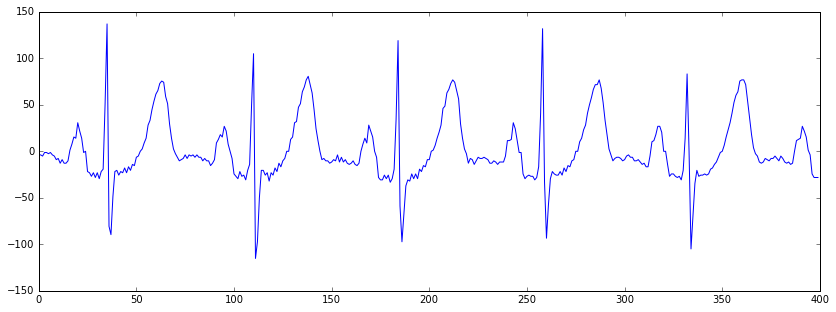

In [7]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1, 1, 1) 
ax.plot(data[:400])

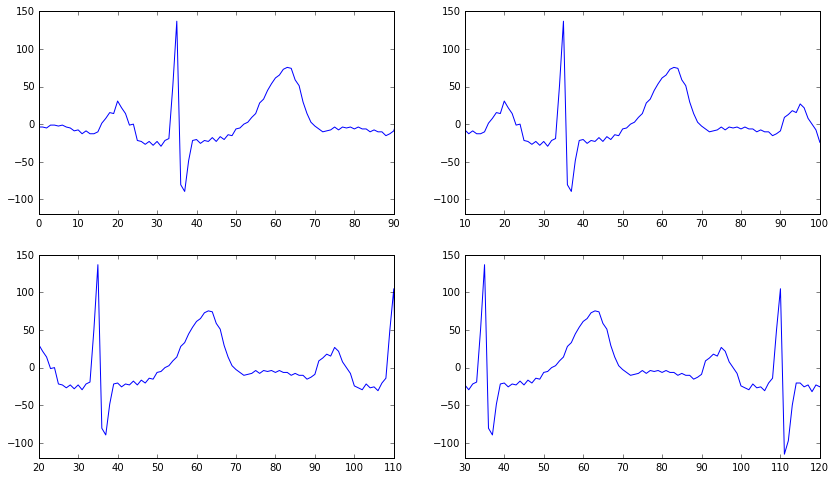

In [8]:
fig = plt.figure(figsize=(14,8))
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1) 
    ax.plot(data[0:200])
    plt.axis([i*10,(i+1)*10+80,-120,150])

[  0.00000000e+00   1.02350294e-02   4.05210942e-02   8.96182794e-02
   1.55516540e-01   2.35517995e-01   3.26347374e-01   4.24286111e-01
   5.25324584e-01   6.25326266e-01   7.20197076e-01   8.06052991e-01
   8.79379061e-01   9.37173308e-01   9.77069628e-01   9.97434662e-01
   9.97434662e-01   9.77069628e-01   9.37173308e-01   8.79379061e-01
   8.06052991e-01   7.20197076e-01   6.25326266e-01   5.25324584e-01
   4.24286111e-01   3.26347374e-01   2.35517995e-01   1.55516540e-01
   8.96182794e-02   4.05210942e-02   1.02350294e-02   1.49975978e-32]


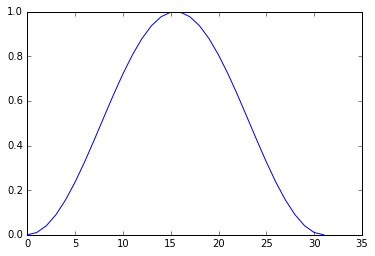

In [9]:
windowSize=32
window=np.array([np.square(np.sin(np.pi * i / (windowSize - 1.0))) for i in range(windowSize)]) 
print(window)
plt.plot(window)

In [10]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [11]:
# ensure windowed_data contains 200000 windows of 32 measurements
windowed_data=rolling_window(data[:400030],windowSize)[::2]
print(windowed_data[0])

[ -3.84500000e+00  -3.84500000e+00  -5.12500000e+00  -1.28500000e+00
  -1.28500000e+00  -2.56500000e+00  -1.28500000e+00  -3.84500000e+00
  -5.12500000e+00  -8.96500000e+00  -7.68500000e+00  -1.28050000e+01
  -8.96500000e+00  -1.28050000e+01  -1.28050000e+01  -1.02450000e+01
   1.28000000e+00   7.68000000e+00   1.53600000e+01   1.40800000e+01
   3.07200000e+01   2.17600000e+01   1.40800000e+01  -1.28500000e+00
  -5.00000000e-03  -2.17650000e+01  -2.30450000e+01  -2.68850000e+01
  -2.30450000e+01  -2.81650000e+01  -2.30450000e+01  -2.94450000e+01]


In [12]:
windowed_data.shape

(200000L, 32L)

In [13]:
r=windowed_data*window
r[0]

array([ -0.00000000e+00,  -3.93536879e-02,  -2.07670608e-01,
        -1.15159489e-01,  -1.99838754e-01,  -6.04103657e-01,
        -4.19356375e-01,  -1.63138010e+00,  -2.69228850e+00,
        -5.60604998e+00,  -5.53471453e+00,  -1.03215086e+01,
        -7.88363328e+00,  -1.20005042e+01,  -1.25113766e+01,
        -1.02187181e+01,   1.27671637e+00,   7.50389474e+00,
         1.43949820e+01,   1.23816572e+01,   2.47619479e+01,
         1.56714884e+01,   8.80459383e+00,  -6.75042091e-01,
        -2.12143056e-03,  -7.10295059e+00,  -5.42751219e+00,
        -4.18106219e+00,  -2.06525325e+00,  -1.14127662e+00,
        -2.35866252e-01,  -4.41604268e-31])

In [14]:
r.shape

(200000L, 32L)

In [15]:
norms=np.linalg.norm(r,axis=1)
broadcasted_norms=np.broadcast_to(norms, r.T.shape).T
broadcasted_norms[0]

array([ 45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141,
        45.87443141,  45.87443141,  45.87443141,  45.87443141])

In [16]:
r = r / broadcasted_norms

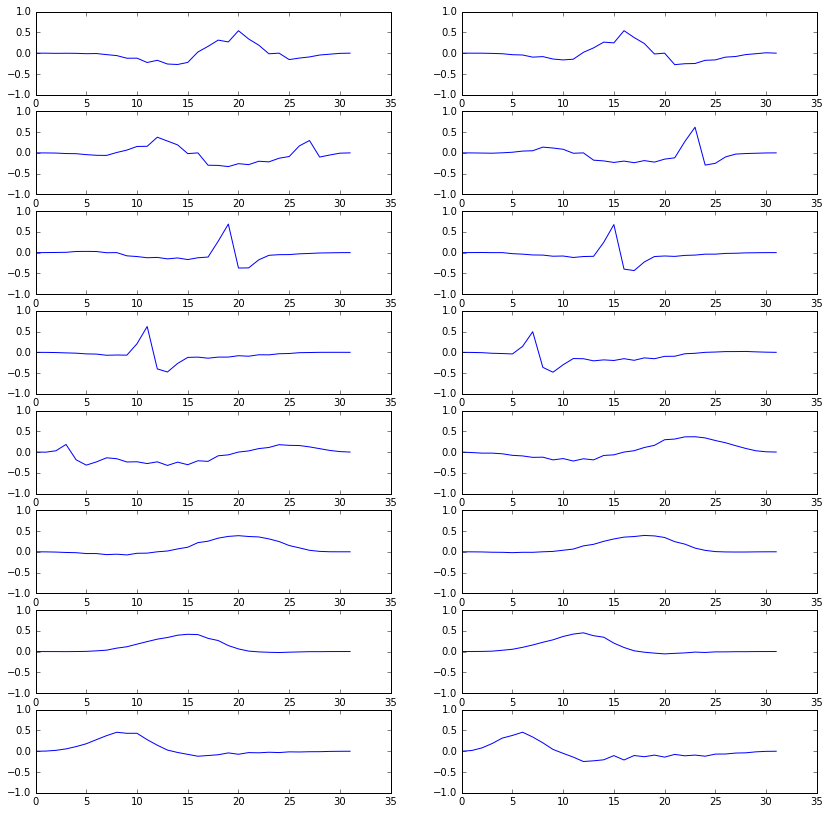

In [17]:
# see how the normalization makes the extremes tend to zero and magnifies the center
fig = plt.figure(figsize=(14,14))
for i in range(16):
    ax = fig.add_subplot(8, 2, i+1) 
    ax.plot(r[i*2])
    plt.ylim(-1,1)

### Calculate Centroids

In [18]:
from sklearn.cluster import KMeans
# km = KMeans(max_iter=10,n_clusters=400).fit(r)
km = KMeans(max_iter=10,n_clusters=50).fit(r[:200000])
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
    n_clusters=50, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

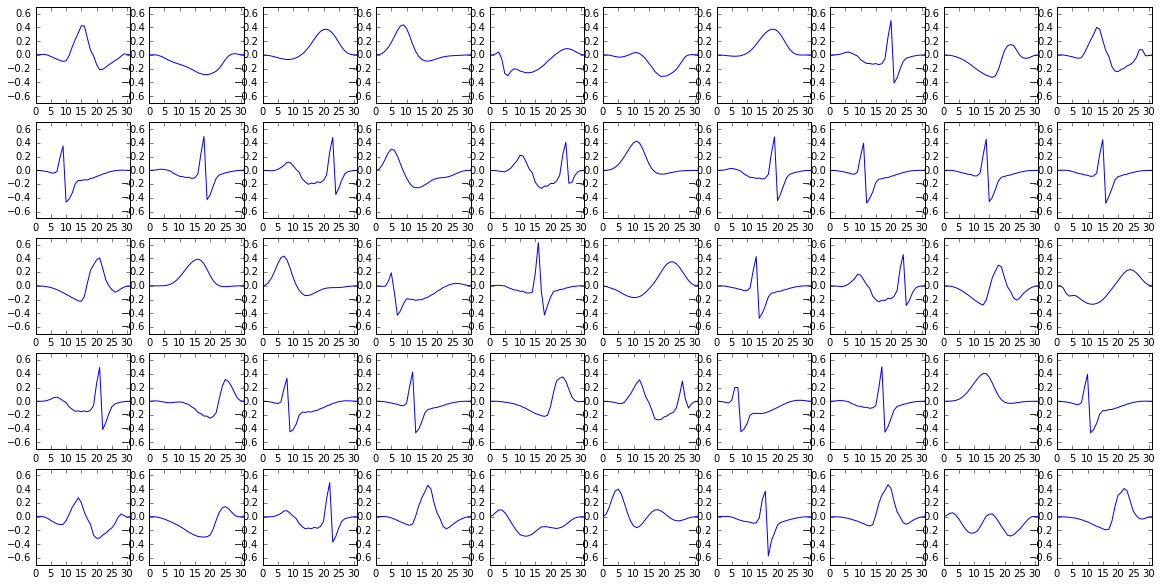

In [19]:
numrows=5
numcols=10
fig = plt.figure(figsize=(numcols*2,numrows*2))
for row in range(numrows):
    for col in range(numcols):
      ax = fig.add_subplot(numrows, numcols, row*numcols + col+1)
      plt.plot(km.cluster_centers_[row*numcols + col])
      plt.ylim(-0.7,0.7)
      plt.xlim(0,31)

## Same without normalization

In [20]:
# ensure windowed_data contains 200000 windows of 32 measurements
windowed_data=rolling_window(data[:400030],windowSize)[::2]
print(windowed_data[0])

[ -3.84500000e+00  -3.84500000e+00  -5.12500000e+00  -1.28500000e+00
  -1.28500000e+00  -2.56500000e+00  -1.28500000e+00  -3.84500000e+00
  -5.12500000e+00  -8.96500000e+00  -7.68500000e+00  -1.28050000e+01
  -8.96500000e+00  -1.28050000e+01  -1.28050000e+01  -1.02450000e+01
   1.28000000e+00   7.68000000e+00   1.53600000e+01   1.40800000e+01
   3.07200000e+01   2.17600000e+01   1.40800000e+01  -1.28500000e+00
  -5.00000000e-03  -2.17650000e+01  -2.30450000e+01  -2.68850000e+01
  -2.30450000e+01  -2.81650000e+01  -2.30450000e+01  -2.94450000e+01]


In [21]:
r=windowed_data # no normalization with sinus or norm

In [22]:
r.shape

(200000L, 32L)

In [23]:
from sklearn.cluster import KMeans
# km = KMeans(max_iter=10,n_clusters=400).fit(r)
km = KMeans(max_iter=10,n_clusters=400).fit(r[:200000])
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10,
    n_clusters=400, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
km.cluster_centers_[0]

array([ 51.55679337,  59.68092593,  66.11088694,  71.45294347,
        73.89317739,  69.03516569,  56.39983431,  40.226423  ,
        24.26502924,  11.6742885 ,   1.98673489,  -2.67302144,
        -6.33169591,  -6.74103314,  -7.15282651,  -8.53269981,
        -6.91584795,  -8.60759259,  -7.79908382,  -7.17766082,
        -5.87011696,  -6.07707602,  -6.01484405,  -4.78717349,
        -6.7358577 ,  -6.33152047,  -4.3477193 ,   0.44119883,
         7.96773879,  14.32892788,  19.36209552,  24.06040936])

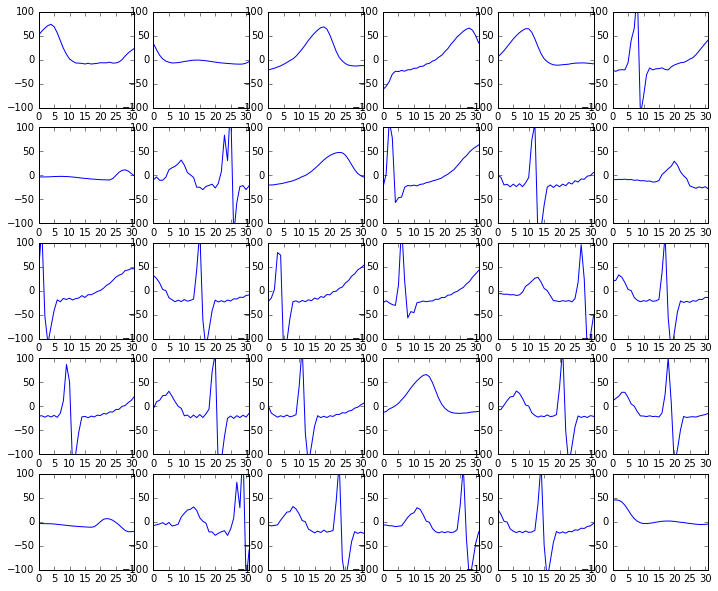

In [25]:
numrows=5
numcols=6
fig = plt.figure(figsize=(numcols*2,numrows*2))
for row in range(numrows):
    for col in range(numcols):
      ax = fig.add_subplot(numrows, numcols, row*numcols + col+1)
      plt.plot(km.cluster_centers_[row*numcols + col])
      plt.ylim(-100,100)
      plt.xlim(0,31)

In [26]:
offset=0
i=0
print(offset + i*windowSize, offset+(i+1)*windowSize)
original_sample=data[offset + i*windowSize : offset+(i+1)*windowSize]
print(original_sample)

(0, 32)
[ -3.84500000e+00  -3.84500000e+00  -5.12500000e+00  -1.28500000e+00
  -1.28500000e+00  -2.56500000e+00  -1.28500000e+00  -3.84500000e+00
  -5.12500000e+00  -8.96500000e+00  -7.68500000e+00  -1.28050000e+01
  -8.96500000e+00  -1.28050000e+01  -1.28050000e+01  -1.02450000e+01
   1.28000000e+00   7.68000000e+00   1.53600000e+01   1.40800000e+01
   3.07200000e+01   2.17600000e+01   1.40800000e+01  -1.28500000e+00
  -5.00000000e-03  -2.17650000e+01  -2.30450000e+01  -2.68850000e+01
  -2.30450000e+01  -2.81650000e+01  -2.30450000e+01  -2.94450000e+01]


In [27]:
np.array([original_sample])

array([[ -3.84500000e+00,  -3.84500000e+00,  -5.12500000e+00,
         -1.28500000e+00,  -1.28500000e+00,  -2.56500000e+00,
         -1.28500000e+00,  -3.84500000e+00,  -5.12500000e+00,
         -8.96500000e+00,  -7.68500000e+00,  -1.28050000e+01,
         -8.96500000e+00,  -1.28050000e+01,  -1.28050000e+01,
         -1.02450000e+01,   1.28000000e+00,   7.68000000e+00,
          1.53600000e+01,   1.40800000e+01,   3.07200000e+01,
          2.17600000e+01,   1.40800000e+01,  -1.28500000e+00,
         -5.00000000e-03,  -2.17650000e+01,  -2.30450000e+01,
         -2.68850000e+01,  -2.30450000e+01,  -2.81650000e+01,
         -2.30450000e+01,  -2.94450000e+01]])

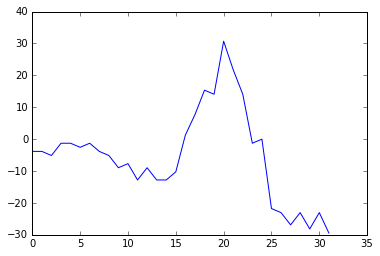

In [28]:
plt.plot(original_sample)

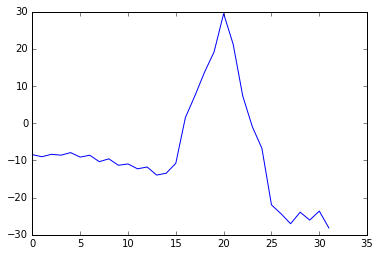

In [29]:
cluster_index=km.predict([original_sample])
plt.plot(km.cluster_centers_[cluster_index[0]])


In [30]:
def get_kmeans(data,windowsSize,step):
    r=rolling_window(data,windowSize)[::step]
    print(windowed_data[0])
    from sklearn.cluster import KMeans
    km = KMeans(max_iter=10,n_clusters=400).fit(r)
    return km

def show_residuals(data,kmeans,windowSize,offset,numrows):
    original_samples=rolling_window(data[offset:offset+numrows*windowSize],windowSize)[::windowSize]
    cluster_indices=kmeans.predict(original_samples)
    centroids=kmeans.cluster_centers_[cluster_indices]
    
    original_samples=rolling_window(data[offset:offset+numrows*windowSize],windowSize)[::windowSize]
    
    cluster_indices=km.predict(original_samples)
    centroids=km.cluster_centers_[cluster_indices]
    fig = plt.figure(figsize=(16,15))
    fig.subplots_adjust(hspace=0.3)
    for i in range(numrows):
        y_min=min(data[offset:offset+numrows*windowSize])
        y_max=max(data[offset:offset+numrows*windowSize])
        ax = fig.add_subplot(numrows, 3, 3*i+1) 
        ax.plot(original_samples[i])
        plt.axis([0,windowSize-1,y_min,y_max])
        plt.title('original')
        plt.grid(True)
        
        ax = fig.add_subplot(numrows, 3, 3*i+2) 
        ax.plot(centroids[i])
        plt.axis([0,windowSize-1,y_min,y_max])
        plt.title('centroid')
        plt.grid(True)

        ax = fig.add_subplot(numrows, 3, 3*i+3) 
        diff=original_samples[i]-centroids[i]
        ax.plot(diff)
        plt.axis([0,windowSize-1,min(y_min,np.min(diff)),max(y_max,np.max(diff))])
        plt.title('residuals')
        plt.grid(True)
        
        plt.plot([0,windowSize], [0,0], 'r--', linewidth=2)

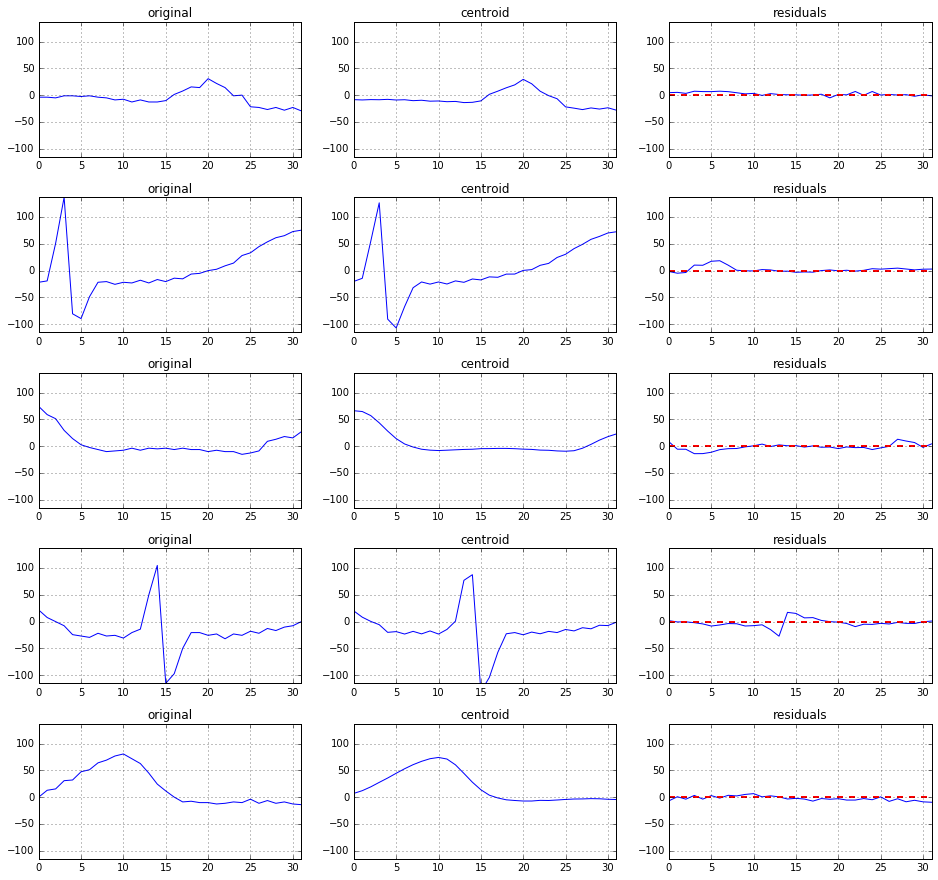

In [31]:
show_residuals(data,km,32,0,5)

### Then we can do anomaly detection on residuals (e.g. z-score or other method)